In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from REMclust import REM
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

### Example 1
The Reinforced EM algorithm is applied to identify pulsar candidates from the High Time Resolution Universe Survey (HTRU2) dataset: https://www.kaggle.com/datasets/charitarth/pulsar-dataset-htru2. Pulsars are highly magnetized rotating neutron stars that emit regular pulses of radiation. The HTRU2 dataset was developed to identify these pulsar candidates from other radiation sources. Each data point in the HTRU2 dataset is described by 8 variables/features, namely mean, standard deviation, the measure of flatness, and asymmetry of the radiation profile, along with mean, standard deviation, the measure of flatness, and asymmetry of the signal-to-noise ratio as a function of dispersion measure (DM-SNR). The target variable is the binary class indicating pulsar candidate.

##### Load glass dataset

In [2]:
df = pd.read_csv('Data/HTRU_2.csv')

df.columns = ['µ IRP','σ IRP', 'excess kurtosis IRP', 'skewness IRP', 
              'µ DM-SNR','σ DM-SNR', 'excess kurtosis DM-SNR', 'skewness DM-SNR', 
              'class']

X = df[df.columns[:-1]]        ## drop the class column
X = np.array(X)

##### Standardize the dataset for fair analysis

In [3]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
n_samples, n_features = X_scaled.shape

##### Applying REM algorithm

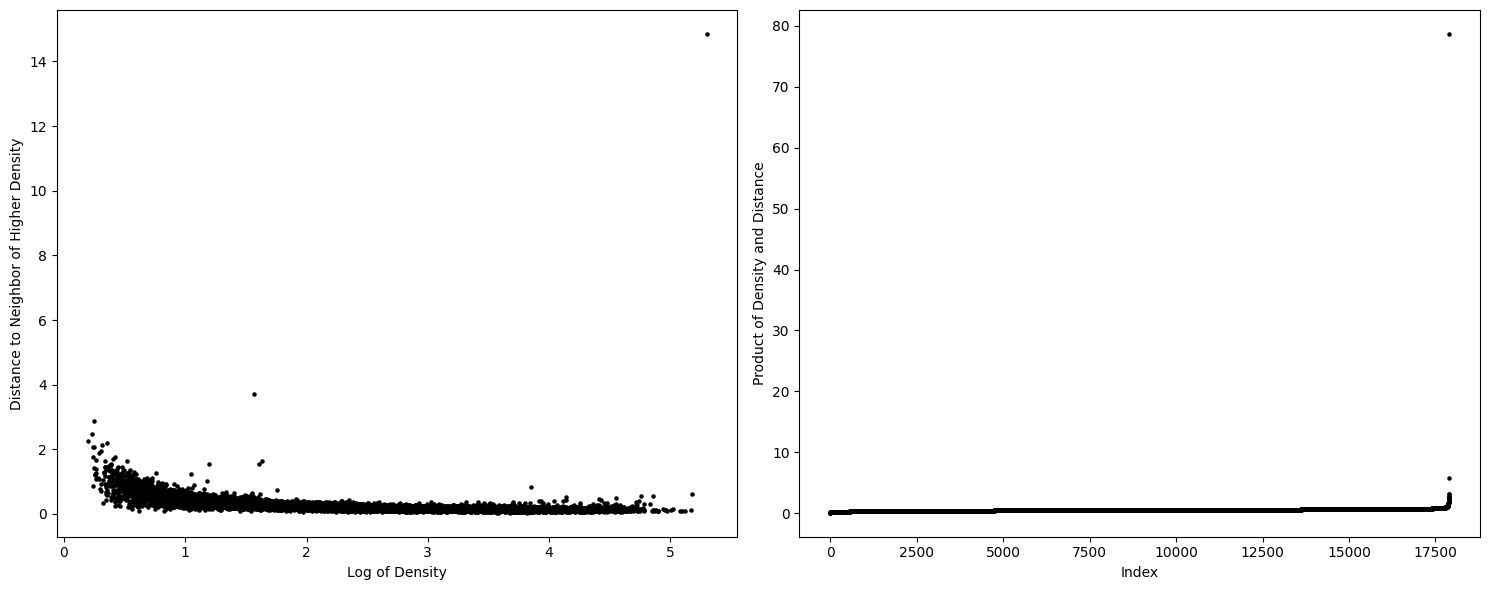

In [4]:
bndwk = int(np.floor(np.min((30, np.sqrt(n_samples)))))
Cluster = REM(data=X_scaled, covariance_type = "full", criteria = "all", bandwidth = bndwk, tol = 1e-3)
Cluster.mode_decision_plot()        ## to estimate the density and distance threshold

In [5]:
# Setting the density threshold and distance threshold value from the mode decision plot 
Cluster.fit(density_threshold = 1.5, distance_threshold = 3.6)
yp = Cluster.get_labels(mixture_selection='aic')        ## predicted labels

2 modes selected.


C:\Users\samue\anaconda3\envs\sisa\lib\site-packages\REMclust\REM.py:432: ComplexWarning: Casting complex values to real discards the imaginary part
  covariances_jitter[i, :, :] = vec.dot(np.diag(val)).dot(np.linalg.inv(vec))


Something to note here is that the classified clusters are labeled '0' and '1'. Now, the user will have to identify which ground truth label corresponds to which predicted label. This can easily be tested with the Folkes-Mallows index metric and the confusion matrix.

In [6]:
yp = np.where(np.array(yp)==0,1,0)        ## corrected yp

# performance metric
fm = metrics.fowlkes_mallows_score(df['class'], yp)
print('Fowlkes-Mallows index (FMI) : %.2f' % (fm))

Fowlkes-Mallows index (FMI) : 0.85


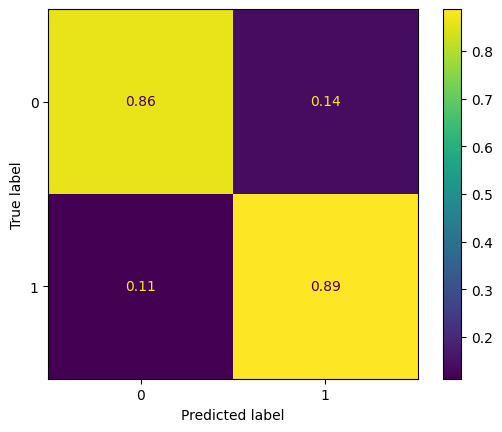

In [7]:
# confusion matrix or classification rate
metrics.ConfusionMatrixDisplay.from_predictions(df['class'], yp, normalize='true')
plt.show()

##### Plotting the classified dataset

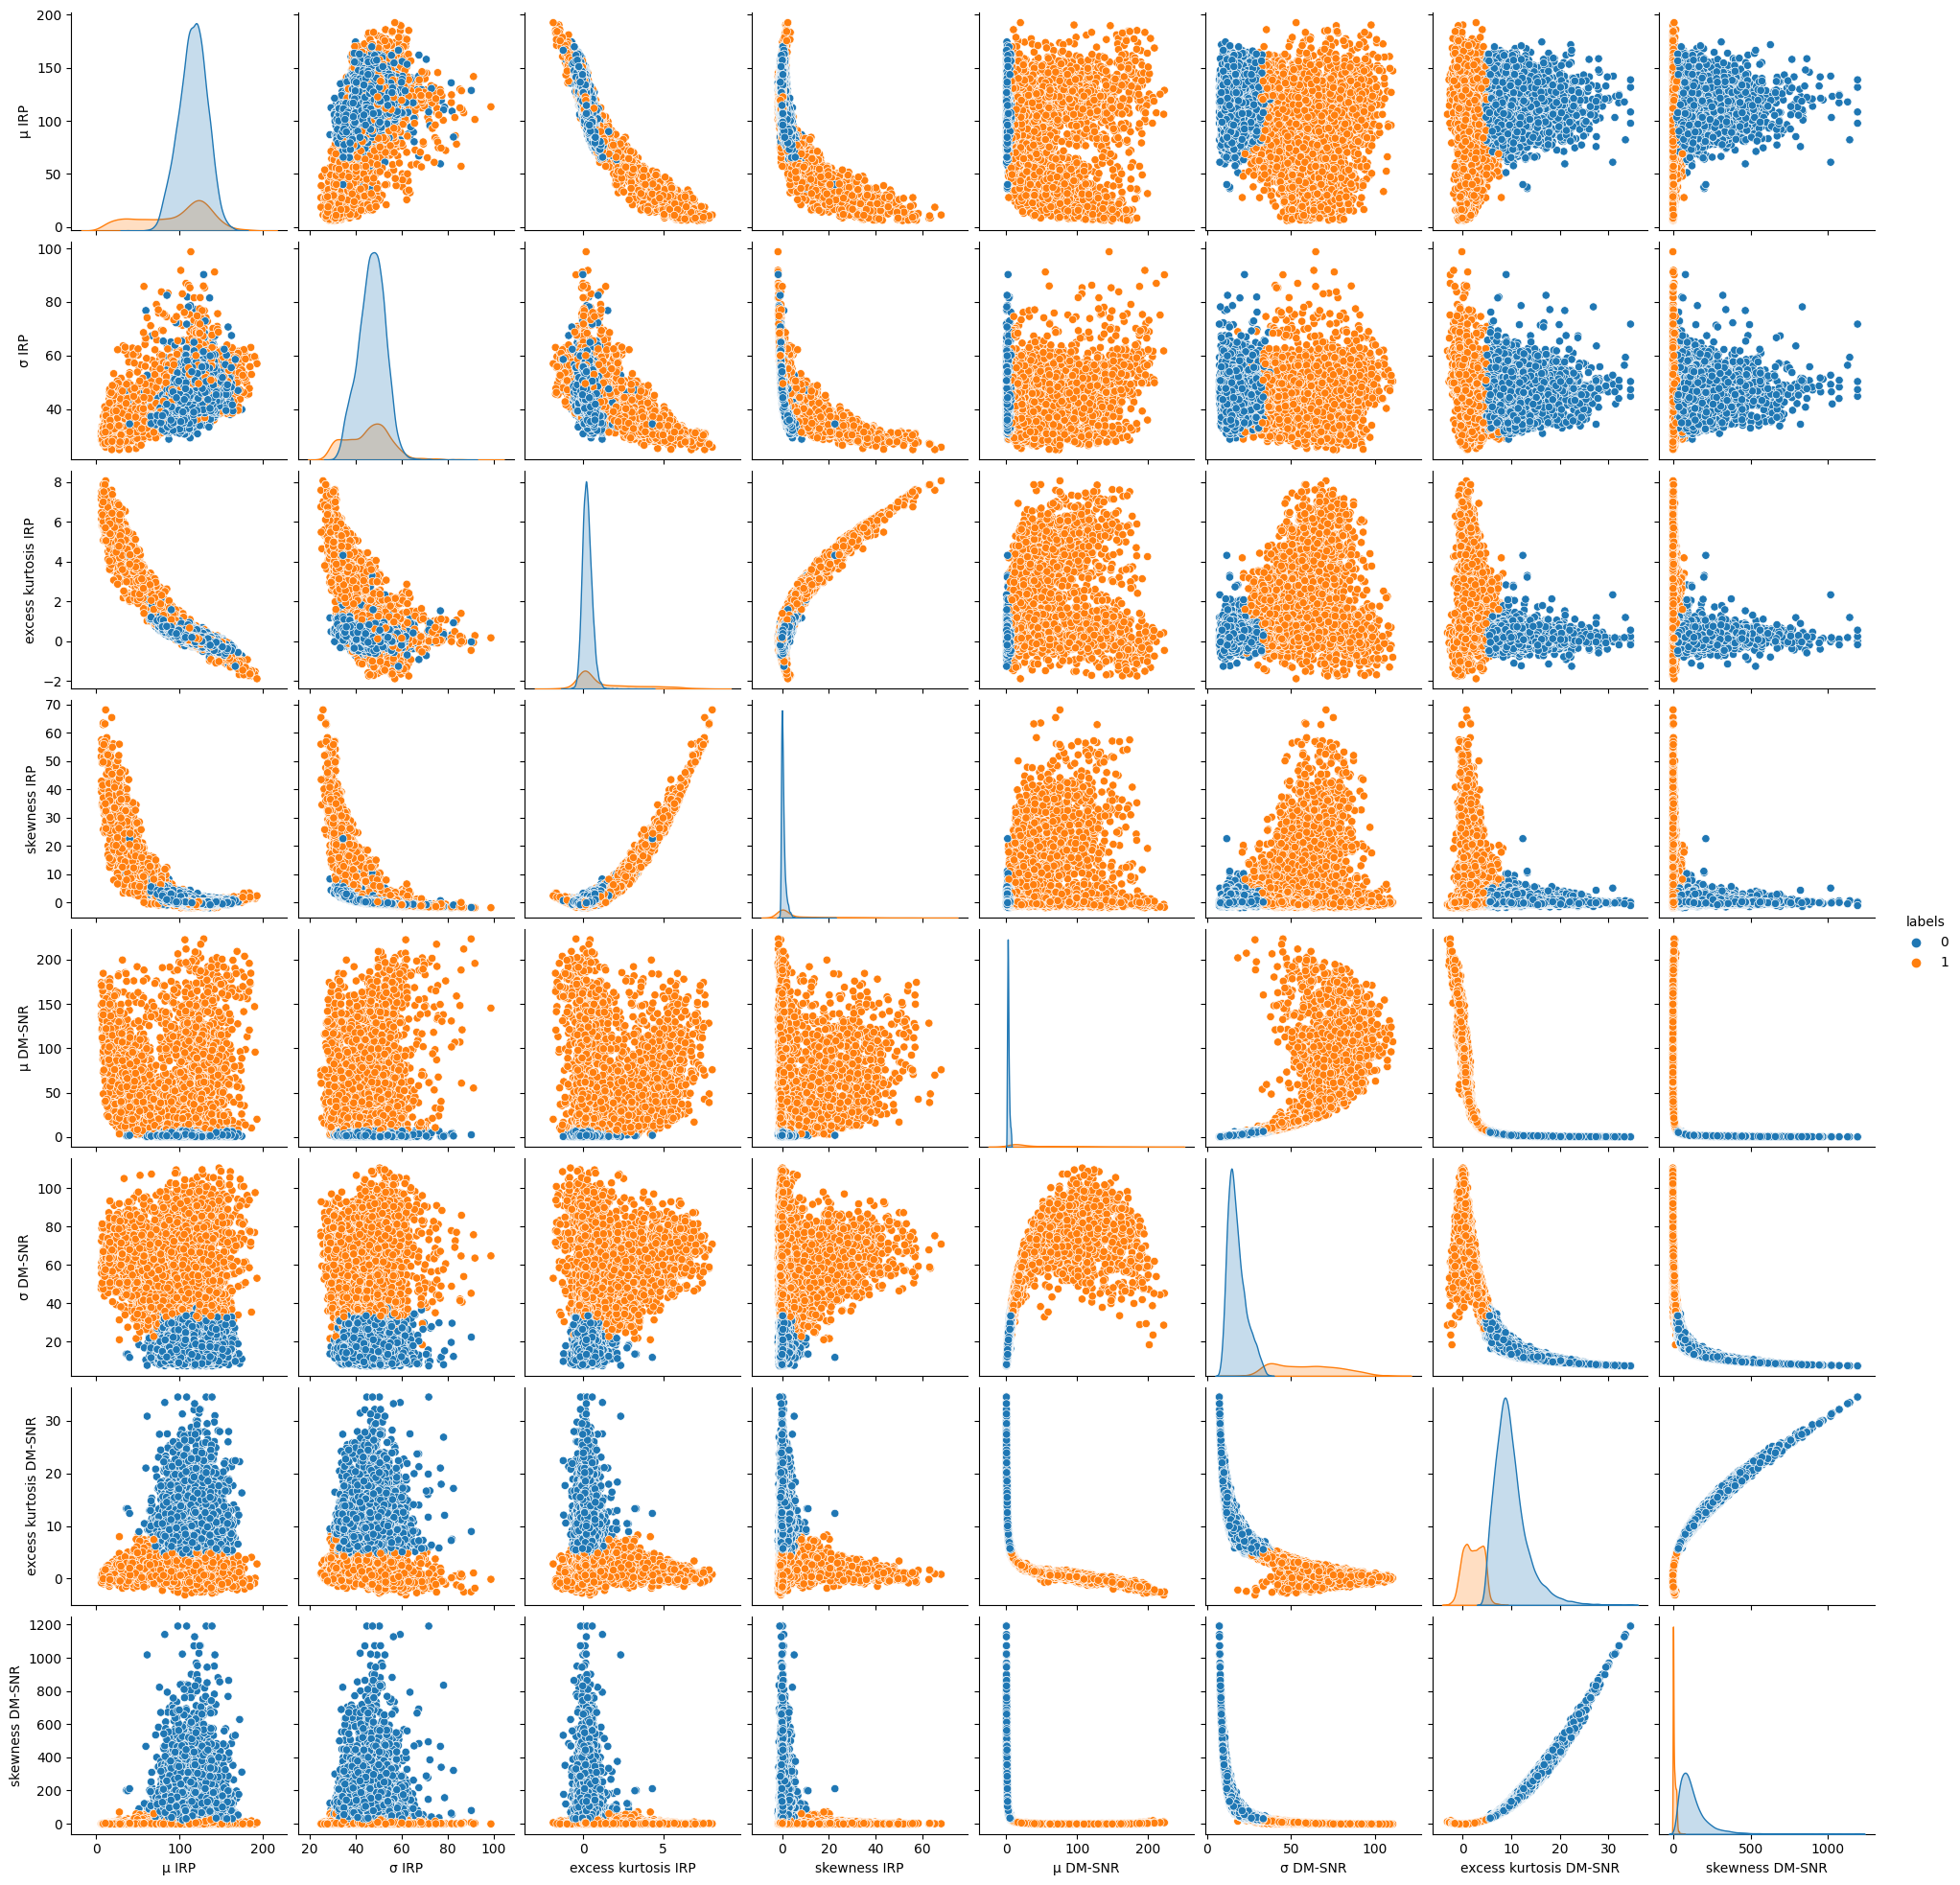

In [8]:
# to plot the pairwise feature plots for 8 attributes/features
df_updated = df[df.columns[:-1]]
df_updated['labels'] = yp
sns.pairplot(df_updated, hue="labels")
plt.show()

##### Visualizing the clustered dataset using PCA

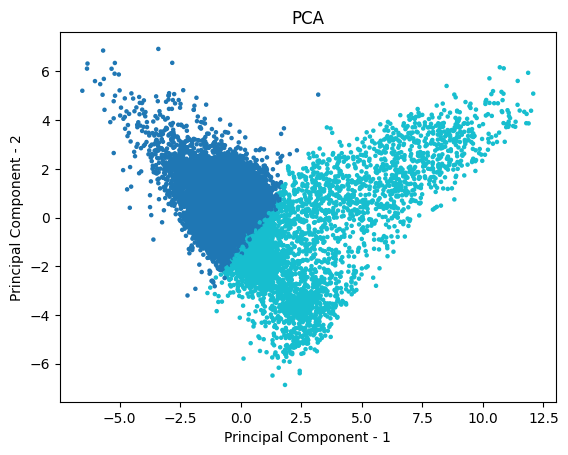

In [9]:
# PCA of HTRU2
pca_X = PCA(n_components=2)
pca_X_scaled = pca_X.fit_transform(X_scaled)

plt.scatter(pca_X_scaled[:, 0], pca_X_scaled[:, 1], s = 5, c = yp, marker = "o", cmap='tab10')
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
plt.title('PCA')
plt.show()

##### Sensitivity analysis

In [10]:
# NMI & ARI
nmi = metrics.normalized_mutual_info_score(df['class'], yp)
ari = metrics.adjusted_rand_score(df['class'], yp)
print("Adjusted Rand Score: \t", ari)
print("Normalized Mutual Information Score: \t", nmi)

Adjusted Rand Score: 	 0.3878884708578086
Normalized Mutual Information Score: 	 0.2743628710506591


2 modes selected.


C:\Users\samue\anaconda3\envs\sisa\lib\site-packages\REMclust\REM.py:432: ComplexWarning: Casting complex values to real discards the imaginary part
  covariances_jitter[i, :, :] = vec.dot(np.diag(val)).dot(np.linalg.inv(vec))


2 modes selected.


C:\Users\samue\anaconda3\envs\sisa\lib\site-packages\REMclust\REM.py:432: ComplexWarning: Casting complex values to real discards the imaginary part
  covariances_jitter[i, :, :] = vec.dot(np.diag(val)).dot(np.linalg.inv(vec))


2 modes selected.


C:\Users\samue\anaconda3\envs\sisa\lib\site-packages\REMclust\REM.py:432: ComplexWarning: Casting complex values to real discards the imaginary part
  covariances_jitter[i, :, :] = vec.dot(np.diag(val)).dot(np.linalg.inv(vec))


1 modes selected.
1 modes selected.


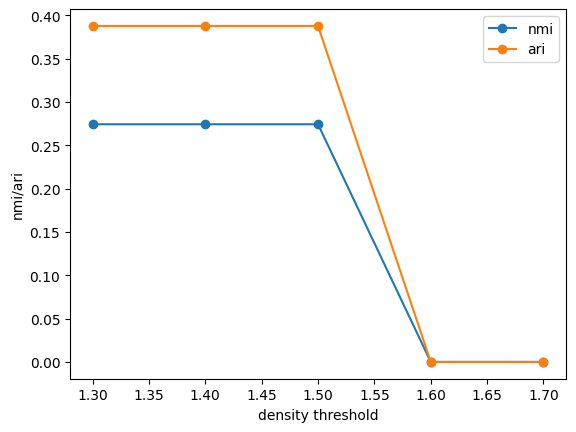

In [11]:
# sensitivity w.r.t density threshold
n = 5
nmi_x = np.zeros((n))
ari_x = np.zeros((n))
dens_thres = [1.3,1.4,1.5,1.6,1.7]

for i in range(n):
    Cluster.fit(density_threshold = dens_thres[i], 
                distance_threshold = 3.6)
    yp_x = Cluster.get_labels(mixture_selection='aic')
    nmi_x[i] = metrics.normalized_mutual_info_score(df['class'].astype(int), yp_x.astype(int))
    ari_x[i] = metrics.adjusted_rand_score(df['class'].astype(int), yp_x.astype(int))

plt.plot(dens_thres, nmi_x, marker = 'o', label='nmi')
plt.plot(dens_thres, ari_x, marker = 'o', label='ari')
plt.xlabel('density threshold')
plt.ylabel('nmi/ari')
plt.legend()
plt.show()

2 modes selected.


C:\Users\samue\anaconda3\envs\sisa\lib\site-packages\REMclust\REM.py:432: ComplexWarning: Casting complex values to real discards the imaginary part
  covariances_jitter[i, :, :] = vec.dot(np.diag(val)).dot(np.linalg.inv(vec))


2 modes selected.


C:\Users\samue\anaconda3\envs\sisa\lib\site-packages\REMclust\REM.py:432: ComplexWarning: Casting complex values to real discards the imaginary part
  covariances_jitter[i, :, :] = vec.dot(np.diag(val)).dot(np.linalg.inv(vec))


2 modes selected.


C:\Users\samue\anaconda3\envs\sisa\lib\site-packages\REMclust\REM.py:432: ComplexWarning: Casting complex values to real discards the imaginary part
  covariances_jitter[i, :, :] = vec.dot(np.diag(val)).dot(np.linalg.inv(vec))


1 modes selected.
1 modes selected.


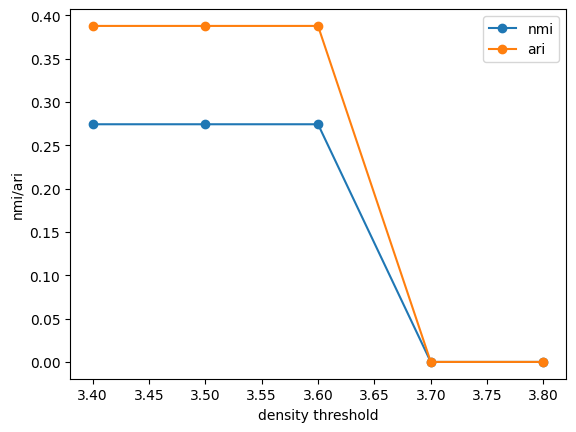

In [12]:
# sensitivity w.r.t distance threshold
n = 5
nmi_x = np.zeros((n))
ari_x = np.zeros((n))
dist_thres = [3.4,3.5,3.6,3.7,3.8]

for i in range(n):
    Cluster.fit(density_threshold = 1.5, 
                distance_threshold = dist_thres[i])
    yp_x = Cluster.get_labels(mixture_selection='aic')
    nmi_x[i] = metrics.normalized_mutual_info_score(df['class'].astype(int), yp_x.astype(int))
    ari_x[i] = metrics.adjusted_rand_score(df['class'].astype(int), yp_x.astype(int))

plt.plot(dist_thres, nmi_x, marker = 'o', label='nmi')
plt.plot(dist_thres, ari_x, marker = 'o', label='ari')
plt.xlabel('density threshold')
plt.ylabel('nmi/ari')
plt.legend()
plt.show()

### Example 2
Now, the Reinforced EM algorithm is applied to the Palmer Archipelago (Antarctica) Penguin Dataset: https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data. The dataset is used to study three species of penguins: Adelie Penguins (Pygoscelis adeliae), Gentoo Penguins (Pygoscelis papua), and Chinstrap Penguins (Pygoscelis antarctica). Each data point in the Penguin dataset is described by 4 variables/features, namely; the length and depth of the upper ridge of a penguin's beak (mm), flipper length (mm), and body mass (g). The target variable is the species class, which includes the three aforementioned species of penguins.

##### Load glass dataset

In [13]:
df = pd.read_csv('Data/penguins_size.csv')

df['species'] = df['species'].map({'Adelie':0, 'Gentoo':1, 'Chinstrap':2})        ## for one hot encoding
df['island'] = df['island'].map({'Torgersen':0, 'Biscoe':1, 'Dream':2})
df['sex'] = df['sex'].map({'MALE':0, 'FEMALE':1})

df = df.dropna()        ## to discard nan value datapoints

X = df[df.columns[2:-1]]        ## considering the length and depth of beak, flipper length and body mass
X = np.array(X)

##### Standardize the dataset for fair analysis

In [14]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
n_samples, n_features = X_scaled.shape

##### Applying REM algorithm

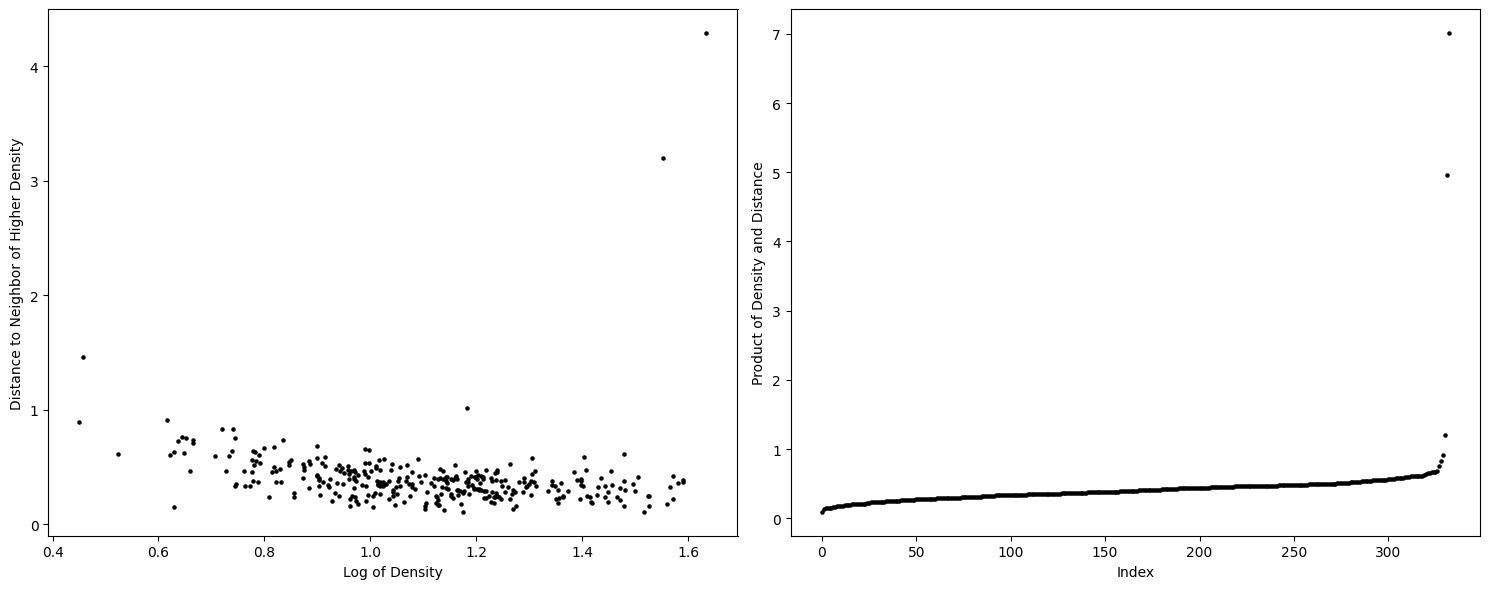

In [15]:
bndwk = int(np.floor(np.min((30, np.square(n_samples)))))
Cluster = REM(data=X_scaled, covariance_type = "full", criteria = "all", bandwidth = bndwk, tol = 1e-3)
Cluster.mode_decision_plot()

In [16]:
# Setting the density threshold and distance threshold value from the mode decision plot 
Cluster.fit(density_threshold = 1.15, distance_threshold = 1.00)
yp = Cluster.get_labels(mixture_selection='aic')

3 modes selected.


Again, it is important to note that the predicted clusters are labeled '0', '1', and '2'. Based on the confusion matrix, it can be deduced that the predicted label '1' corresponds to the ground truth '2', and vice versa. Accordingly, appropriate corrections have been made.

In [17]:
yp[yp == 2] = 3; yp[yp == 1] = 2; yp[yp == 3] = 1;        ## corrected yp

# performance metric
fm = metrics.fowlkes_mallows_score(df['species'], yp)
print('Fowlkes-Mallows index (FMI) : %.2f' % (fm))

Fowlkes-Mallows index (FMI) : 0.85


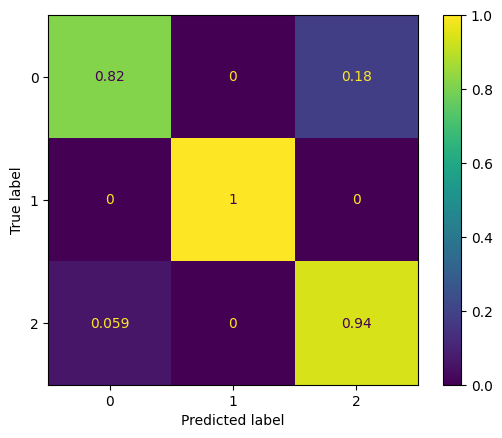

In [18]:
# confusion matrix or classification rate
metrics.ConfusionMatrixDisplay.from_predictions(df['species'], yp, normalize='true')
plt.show()

##### Plotting the classified dataset

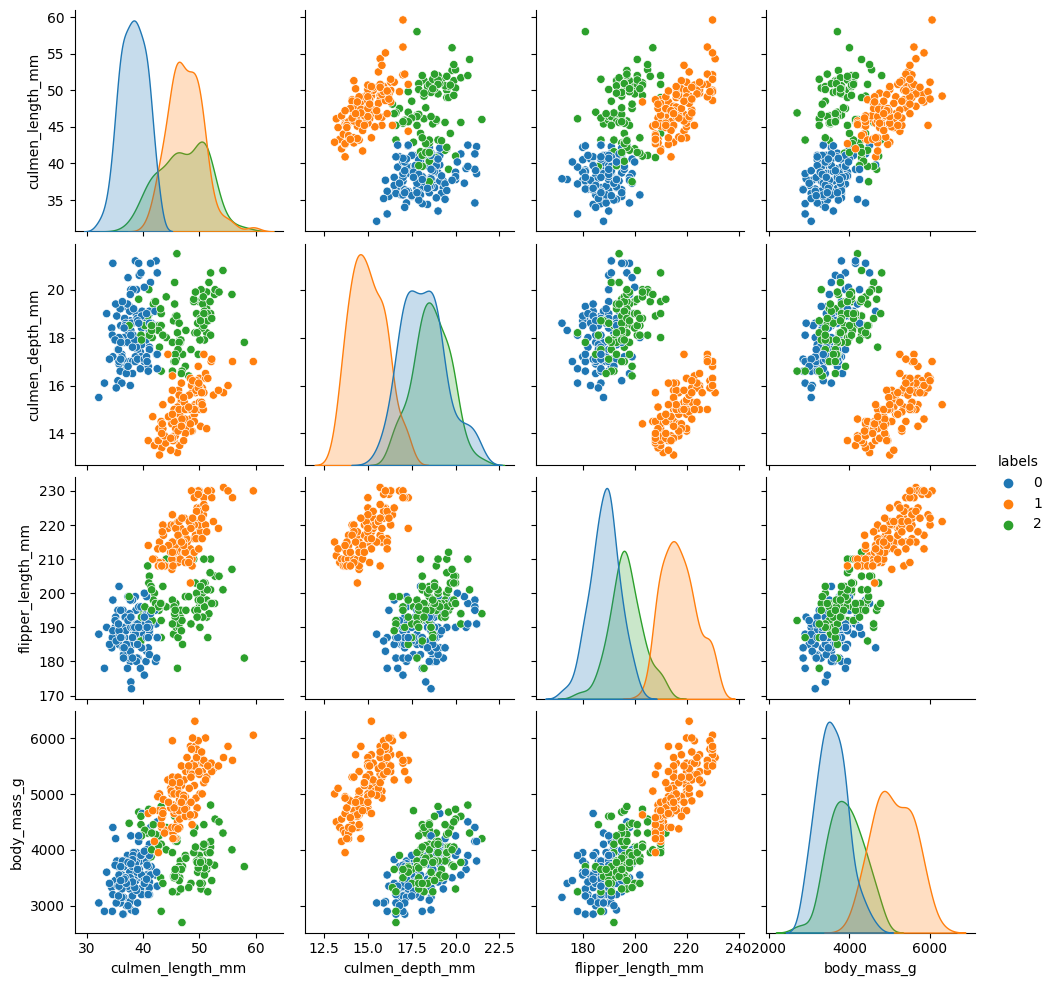

In [19]:
# to plot the pairwise feature plots for 8 attributes/features
df_updated = df[df.columns[2:-1]]
df_updated = df_updated.assign(labels=yp)
sns.pairplot(df_updated, hue="labels", palette='tab10')
plt.show()

##### Visualizing the clustered dataset using PCA

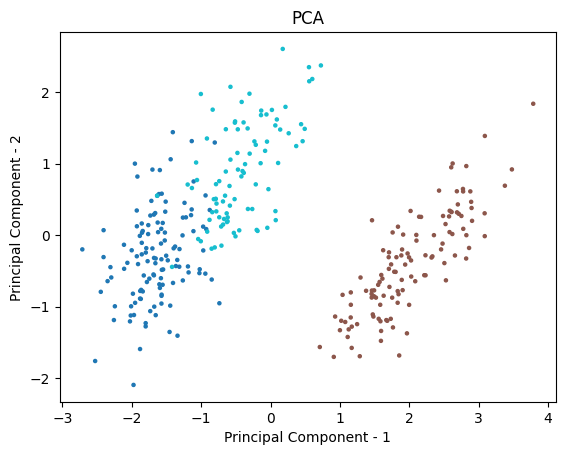

In [20]:
pca_X = PCA(n_components=2)
pca_X_scaled = pca_X.fit_transform(X_scaled)

plt.scatter(pca_X_scaled[:, 0], pca_X_scaled[:, 1], s = 5, c = yp, marker = "o", cmap='tab10')
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
plt.title('PCA')
plt.show()

##### Sensitivity analysis

In [21]:
# NMI & ARI
nmi = metrics.normalized_mutual_info_score(df['species'].astype(int), yp.astype(int))
ari = metrics.adjusted_rand_score(df['species'].astype(int), yp.astype(int))
print("Adjusted Rand Score: \t", ari)
print("Normalized Mutual Information Score: \t", nmi)

Adjusted Rand Score: 	 0.7740574481288712
Normalized Mutual Information Score: 	 0.7785511759363766


3 modes selected.
3 modes selected.
3 modes selected.
2 modes selected.
2 modes selected.


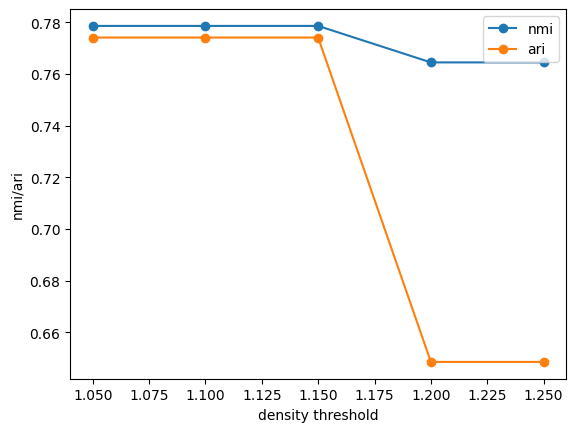

In [22]:
# sensitivity w.r.t density threshold
n = 5
nmi_x = np.zeros((n))
ari_x = np.zeros((n))
dens_thres = [1.05,1.10,1.15,1.20,1.25]

for i in range(n):
    Cluster.fit(density_threshold = dens_thres[i], 
                distance_threshold = 1.0)
    yp_x = Cluster.get_labels(mixture_selection='aic')
    nmi_x[i] = metrics.normalized_mutual_info_score(df['species'].astype(int), yp_x.astype(int))
    ari_x[i] = metrics.adjusted_rand_score(df['species'].astype(int), yp_x.astype(int))

plt.plot(dens_thres, nmi_x, marker = 'o', label='nmi')
plt.plot(dens_thres, ari_x, marker = 'o', label='ari')
plt.xlabel('density threshold')
plt.ylabel('nmi/ari')
plt.legend()
plt.show()

3 modes selected.
3 modes selected.
3 modes selected.
2 modes selected.
2 modes selected.


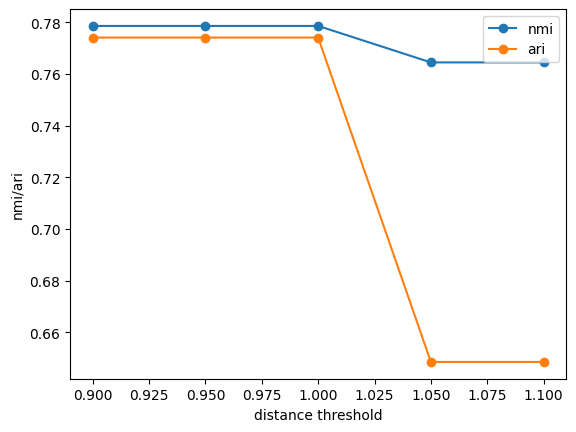

In [23]:
# sensitivity w.r.t distance threshold
n = 5
nmi_x = np.zeros((n))
ari_x = np.zeros((n))
dist_thres = [0.90,0.95,1.00,1.05,1.10]

for i in range(n):
    Cluster.fit(density_threshold = 1.0, 
                distance_threshold = dist_thres[i])
    yp_x = Cluster.get_labels(mixture_selection='aic')
    nmi_x[i] = metrics.normalized_mutual_info_score(df['species'].astype(int), yp_x.astype(int))
    ari_x[i] = metrics.adjusted_rand_score(df['species'].astype(int), yp_x.astype(int))

plt.plot(dist_thres, nmi_x, marker = 'o', label='nmi')
plt.plot(dist_thres, ari_x, marker = 'o', label='ari')
plt.xlabel('distance threshold')
plt.ylabel('nmi/ari')
plt.legend()
plt.show()

### Conclusion
We can observe that the REM algorithm for cluster analysis using Gaussian Mixture Models (GMM) provides a reliable way to estimate the parameters for initializing the GMM clustering. In example 1, the mode_decision_plot() displays the log of density against the distance to the neighbor of higher density, clearly depicting the density threshold as 1.50 and the distance threshold as 3.60. By utilizing these derived density and distance thresholds, the REM() function efficiently clusters the given dataset. Furthermore, the threshold values from the mode_decision_plot() are validated and confirmed in the sensitivity analysis, where the performance metrics decline beyond the derived threshold values. The same observations are made in example 2, where the density threshold and the distance threshold are 1.15 and 1.00, respectively.